In [1]:
import os 
import pandas as pd  
from torchtext.data.utils import get_tokenizer
import torch
from collections import Counter
from torchtext.vocab import Vocab
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
en_tokenizer = get_tokenizer('spacy', language="en_core_web_sm")

def build_vocab(sentences):
    counter = Counter()
    for sentence in sentences:
        sentence = sentence.lower()
        counter.update(en_tokenizer(sentence))
    return Vocab(counter, specials=['<UNK>', '<PAD>', '<SOS>', '<EOS>'])

def data_process(sentence, vocab):
    sentence = sentence.lower()
    vocab_tensor = torch.tensor([vocab[token] for token in en_tokenizer(sentence)],
                            dtype=torch.long)
    return vocab_tensor

In [3]:
class Flickr8k(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.csv_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        self.imgs = self.csv_frame["image"]
        self.captions = self.csv_frame["caption"]
        self.vocab = build_vocab(self.captions.to_list())

    def __len__(self):
        return len(self.csv_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.imgs[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        tokenized_caption = [torch.tensor(self.vocab["<SOS>"])]
        tokenized_caption.extend(data_process(self.captions[idx], self.vocab))
        tokenized_caption.append(torch.tensor(self.vocab["<EOS>"]))
        
        return image, torch.tensor(tokenized_caption)

class Collate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
    
    def __call__(self, data):
        imgs = torch.stack([i[0] for i in data])
        targets = [i[1] for i in data]
        lengths = [len(i[1]) for i in data]
        # add padding to captions to make them match the largest caption in the batch
        targets = pad_sequence(targets, padding_value=self.pad_idx, batch_first=True)
        return imgs, targets, lengths

def initialize_loader(dataset, batch_size=64):
    pad_idx = dataset.vocab["<PAD>"]
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=Collate(pad_idx),
    )
    return dataloader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
<SOS> two different breeds of brown and white dogs play on the beach . <EOS>


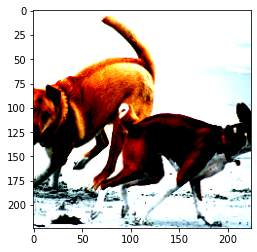

In [4]:
if __name__ == "__main__":
    # TODO: Split data into train, validation, test before initializing loader
    transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ])
    data = Flickr8k(csv_file="flickr8k/captions.txt", root_dir="flickr8k/images", transform=transform)
    loader = initialize_loader(data)
    
    plt.imshow(data[100][0].permute(1, 2, 0))
    sentence = map(lambda x: data.vocab.itos[x], data[100][1])
    print(" ".join(sentence))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([64, 23])
<SOS> a person with a long ponytail walks along a waterway under a tunnel <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


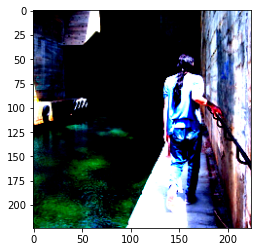

In [5]:
for i, (imgs, captions, lengths) in enumerate(loader):
    plt.imshow(imgs[0].permute(1, 2, 0))
    sentence = map(lambda x: data.vocab.itos[x], captions[0])
    print(captions.shape)
    print(" ".join(sentence))
    break